In [1]:
import os, sys

# Local modules
sys.path.append('./..')
import data_processing
import visualization
import stats

# Data management
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.patches import Patch


In [192]:
# Force reload modules  ## CAN BE REMOVED WHEN DONE
import importlib
importlib.reload(visualization)
importlib.reload(stats)
importlib.reload(data_processing)

<module 'data_processing' from '/scratch/jaap/SPVGazeAnalysis/visual_search/./../data_processing.py'>

### Calculate localization errors and search durations

#### Load experimental data

In [100]:
# All data
# path = '../../_Datasets/SPVGazeData/_preprocessed_downsampled_10'
path = '../../_Datasets/SPVGazeData/_preprocessed'
exp_data, calbr_data = data_processing.load_preprocessed_data(path)
subjects = data_processing.SUBJECTS # or specify subset of subjects

## Load the experimental data
data = exp_data['EngineDataRecord'].copy()
data = data.loc[data.Block>7] # Exclude practice blocks
data = data.loc[(data.Subject.isin(subjects))] # Specified subjects

# Visual search data
data = data.loc[data.ExperimentalTask== 'VisualSearch']

/scratch/jaap/SPVGazeAnalysis/visual_search/./../data_processing.py:105: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  exp_data[data_key] = pd.read_csv(os.path.join(path,fn),sep='\t')
/scratch/jaap/SPVGazeAnalysis/visual_search/./../data_processing.py:103: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  calibr_data[data_key] = pd.read_csv(os.path.join(path,fn),sep='\t')


In [112]:
trial_data = exp_data['TrialConfigRecord'].set_index('TrialIdentifier')
data['ReportedSubjectiveRating'] = trial_data.loc[data.TrialIdentifier].ReportedSubjectiveRating.values

#### Calculate search durations and localization errors for each search instance

In [126]:
def calc_search_durations(data):
    """Add search duration, reported events, etc. to the columns (performs inplace operations on input dataframe)""" 

    # Useful grouping indices
    trial_index= ['TrialIdentifier',]
    targ_index = ['TrialIdentifier','ReportedEventsCount'] # To group by visual search instance (within a trial)
    time_index = ['TrialIdentifier', 'TimeStamp'] # To index by timestamp (unique frame identifier)

    # Total reported objects
    total_reported = data.groupby(trial_index).ReportedEventsCount.max()
    data['TotalReportedEvents'] = total_reported.loc[data.TrialIdentifier].values
    data['ReportedAsFound'] = data.ReportedEventsCount < data.TotalReportedEvents

    # Find and calculate the time between 'event triggers' reported by subject
    start_trial = data.ne(data.shift()).TrialIdentifier # True for first frame of each trial
    event_occurred = data.groupby(trial_index).ReportedEventsCount.diff() > 0 # True for frames where event count increases (trigger was pressed)
    start_of_search = data.where(start_trial | event_occurred).TimeStamp.ffill()  # Timestamps for the start of search 
    start_of_search.loc[data.ReportedEventsCount > 0] += 1e7 # Next visual search instances starts 1 second after the previous one ended
    data['SearchDuration'] = (data.TimeStamp - start_of_search) * 1e-7
    data['SecondsSinceTrialStart'] =  (data.TimeStamp - data.where(start_trial).TimeStamp.ffill()) * 1e-7

    # From all frames, select the frames where trigger was pressed (event)
    event_occurred = data.groupby('TrialIdentifier').ReportedEventsCount.diff() > 0
    event_frames = data.loc[event_occurred].copy()
    
    # Some data (e.g. search duration) are found in the final frame before the event
    final_frames = data.shift().loc[event_occurred]
    copy_from_final = ['ReportedEventsCount', 'SearchDuration', 'ReportedAsFound']
    event_frames[copy_from_final] = final_frames[copy_from_final]
    
    return event_frames

    
def angle_between(a, b):
    """Calculate the shortest angle between two complex numbers (represented as vectors on the complex plane)
    return value in degrees"""
    theta = np.angle(a) - np.angle(b)
    theta *= 180/np.pi  #convert to degrees
    theta = (theta + 180) % 360 - 180 # find the shortest angle (e.g. -270 -> 90 deg.)
    return theta

def calc_localization_errors(events, targets, columns=None):

    out = events.copy()
    
    # Positions of the sensors in world space
    out['OrgPosXZ'] = (out.XROriginPosX + out.XROriginPosZ * 1j).values
    out['HeadPosXZ'] = (out.XRHeadPosX + out.XRHeadPosZ*1j).values
    out['HandPosXZ'] = (out.HandRPosX + out.HandRPosZ*1j).values

    # Position of the targets in world space
    out['TrgPosXZ'] = (targets.loc[out['ActiveTarget']].PosX + \
                       targets.loc[out['ActiveTarget']].PosZ * 1j).values

    # Pointing locations (world space)
    out['HandPntXZ'] = (out.PointLocationHandX + out.PointLocationHandZ*1j).values
    out['HeadPntXZ'] = (out.PointLocationHeadX + out.PointLocationHeadZ*1j).values
    out['EyePntXZ'] = (out.PointLocationEyeX + out.PointLocationEyeZ*1j).values
    
    # Raycasts from hand
    out['Hand2HandPnt'] = out.HandPntXZ - out.HandPosXZ # Raycast hit location (hand) w.r.t. hand pos
    out['Head2HandPnt'] = out.HandPntXZ - out.HeadPosXZ # Raycast hit location (hand) w.r.t. head pos
    
    # Raycasts from head and eyes
    out['Head2HeadPnt'] = out.HeadPntXZ - out.HeadPosXZ # Raycast hit location (head) w.r.t. head pos
    out['Head2EyePnt'] =  out.EyePntXZ - out.HeadPosXZ # Raycast hit location (eyes) w.r.t. head pos
    
    # Target positions
    out['Hand2Targ'] = out.TrgPosXZ - out.HandPosXZ # Target location w.r.t. hand pos
    out['Head2Targ'] = out.TrgPosXZ - out.HeadPosXZ # Target location w.r.t. head pos

    # Localization errors (angles with respect to vector from head to target)
    out['LocalizationErrorHand'] = angle_between(out.Head2HandPnt, out.Head2Targ)
    out['LocalizationErrorHead'] = angle_between(out.Head2HeadPnt, out.Head2Targ)
    out['LocalizationErrorEyes'] = angle_between(out.Head2EyePnt, out.Head2Targ)
    out['AbsLocalizationErrorHand'] = out.LocalizationErrorHand.abs()
    out['AbsLocalizationErrorHead'] = out.LocalizationErrorHead.abs()
    out['AbsLocalizationErrorEyes'] =  out.LocalizationErrorEyes.abs()
    
    # Relative errors (mismatch)
    out['HeadHandMismatch'] = (out.LocalizationErrorHead - out.LocalizationErrorHand  + 180) % 360 - 180
    out['EyeHandMismatch'] = (out.LocalizationErrorEyes - out.LocalizationErrorHand  + 180) % 360 - 180
    out['HeadEyeMismatch'] = (out.LocalizationErrorHead - out.LocalizationErrorEyes + 180) % 360 - 180
    
    if columns is None:
        columns = ['ActiveTarget','Subject', 'Block', 'RelativeTrialNumber', 
                   'ExperimentalTask', 'GazeCondition','TotalReportedEvents', 
                   'ReportedSubjectiveRating', 'ReportedAsFound', 'HeadPosXZ', 
                   'HandPosXZ', 'OrgPosXZ', 'TrgPosXZ', 'HandPntXZ', 'HeadPntXZ',
                   'EyePntXZ',  'Hand2HandPnt', 'Head2HandPnt','Head2HeadPnt',
                   'Head2EyePnt', 'Hand2Targ', 'Head2Targ', 
                   'SearchDuration', 'LocalizationErrorHand',
                   'LocalizationErrorHead','LocalizationErrorEyes',
                   'AbsLocalizationErrorHand', 'AbsLocalizationErrorHead',
                   'AbsLocalizationErrorEyes', 'HeadHandMismatch', 'EyeHandMismatch',
                   'HeadEyeMismatch','TimeStamp', 'SecondsSinceTrialStart']
    

    return out.set_index(['TrialIdentifier','ReportedEventsCount'])[columns]


# Calculate the search durations of the completed searches
completed_searches = calc_search_durations(data)
unfinished_searches = data[data.ne(data.shift(-1)).TrialIdentifier] # last frame of each trial

# Calculate the localization errors
targets = data_processing.get_target_locations()
localization_errors = calc_localization_errors(completed_searches, targets=targets)

#### Exclude invalid searches

In [127]:
MAX_LOCALIZATION_ERROR = 15 # maximal degrees of deviation to count as a correctly found target
MINIMAL_ACCURACY = 0.8 # subjects with lower overall-accuracy will be excluded
MINIMAL_TARGETS = 2 # subjects who have found less targets in all of the conditions are excluded

## Identify the correctly found targets (based on MAX_LOCALIZATION_ERROR)
# For the head-steered conditions, use the head deviation, for gaze-steered, use the eye deviations
reference = {'GazeAssistedSampling': 'AbsLocalizationErrorEyes',
             'GazeIgnored': 'AbsLocalizationErrorHead',
             'SimulationFixedToGaze': 'AbsLocalizationErrorHead'}
localization_errors['WhichReference'] = localization_errors.GazeCondition.replace(reference)
localization_errors['ReferenceError'] = localization_errors.apply(lambda x: x[x.WhichReference], axis=1)
localization_errors['FoundCorrectTarget'] = localization_errors['ReferenceError'] < MAX_LOCALIZATION_ERROR


## Exclude invalid targets and subjects 

# Bad-performing subjects
accuracy_per_subject = localization_errors.groupby('Subject').FoundCorrectTarget.mean()
n_targets_per_cond = localization_errors.groupby(['Subject','GazeCondition']).ActiveTarget.count().unstack(fill_value=0)
too_few_targets = n_targets_per_cond.loc[(n_targets_per_cond < MINIMAL_TARGETS).any(axis=1)].index
too_low_pointing_acc = accuracy_per_subject.loc[accuracy_per_subject < MINIMAL_ACCURACY].index
exclude_subjects = too_few_targets.union(too_low_pointing_acc)


# Difficult targets
accuracy_per_target = localization_errors.groupby('ActiveTarget').FoundCorrectTarget.mean()
exclude_targets = accuracy_per_target.loc[accuracy_per_target < MINIMAL_ACCURACY].index
invalid_mask = localization_errors.Subject.isin(exclude_subjects) | localization_errors.ActiveTarget.isin(exclude_targets)


## Save the valid searches and succesful (correct) searches
valid_searches = localization_errors.loc[~invalid_mask]
successful_searches =  valid_searches.loc[valid_searches.FoundCorrectTarget]

# Save data used for plotting
if not os.path.exists('./out'):
    os.makedirs('./out')
    
completed_searches.to_csv('out/all_completed_searches.tsv', sep='\t', index=False)
unfinished_searches.to_csv('out/unfinished_searches.tsv', sep='\t', index=False)
localization_errors.to_csv('out/all_localization_errors.tsv', sep='\t', index=True)
valid_searches.to_csv('out/valid_localization_errors.tsv', sep='\t', index=True)

In [171]:
## Uncomment to display tables 
# n_targets_per_cond
# accuracy_per_subject
# accuracy_per_target

### Visualize

#### All localization errors

In [128]:
# Load data for plotting
localization_errors = pd.read_csv('out/all_localization_errors.tsv', sep='\t').set_index(['TrialIdentifier','ReportedEventsCount'])
valid_searches =  pd.read_csv('out/valid_localization_errors.tsv', sep='\t').set_index(['TrialIdentifier','ReportedEventsCount'])
successful_searches =  valid_searches.loc[valid_searches.FoundCorrectTarget]

Text(0.5, 1.0, 'All_searches')

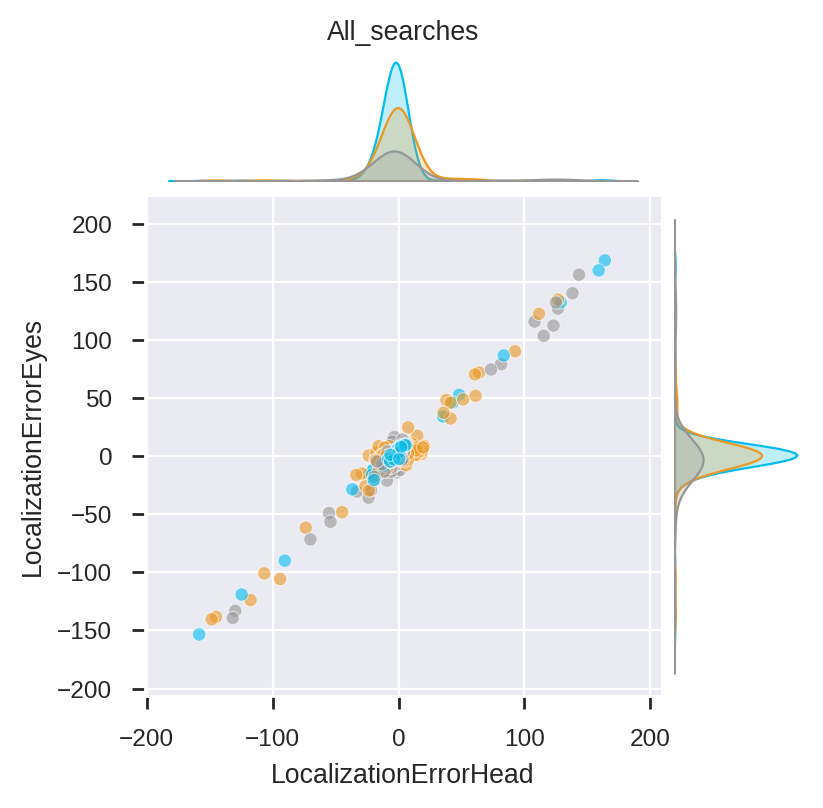

In [129]:
visualization.set_figurestyle()
handles = visualization.joint_distribution_plots(localization_errors, [('LocalizationErrorHead','LocalizationErrorEyes')])
handles[1].set_title('All_searches')

#### Difficult targets / bad subjects

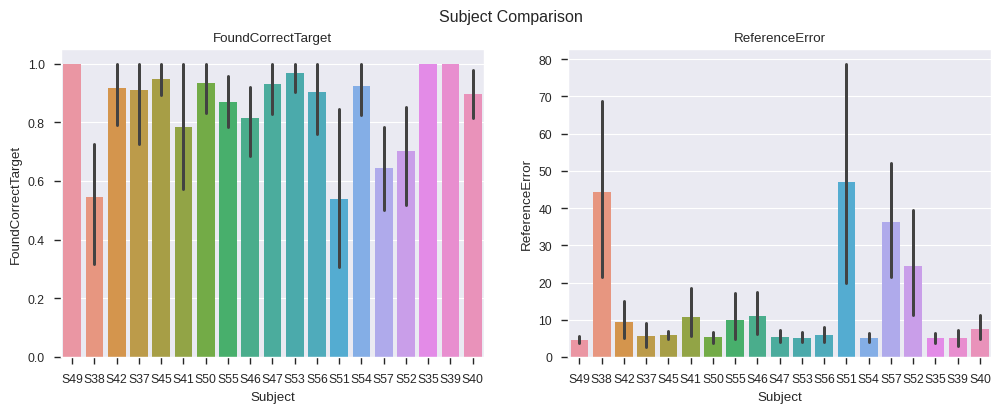

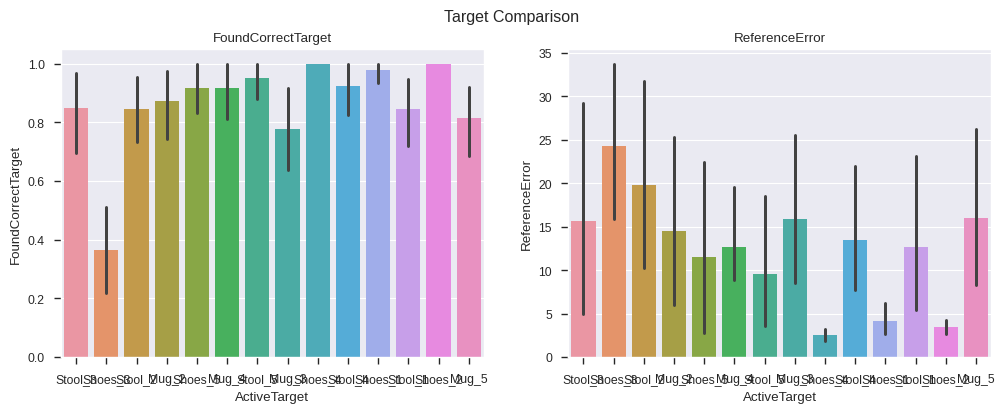

In [130]:
visualization.bar_plots(localization_errors, x='Subject', endpoints=['FoundCorrectTarget', 'ReferenceError'], order=None)
plt.suptitle('Subject Comparison')
plt.show()

visualization.bar_plots(localization_errors, x='ActiveTarget', endpoints=['FoundCorrectTarget', 'ReferenceError'], order=None)
plt.suptitle('Target Comparison')
plt.show()

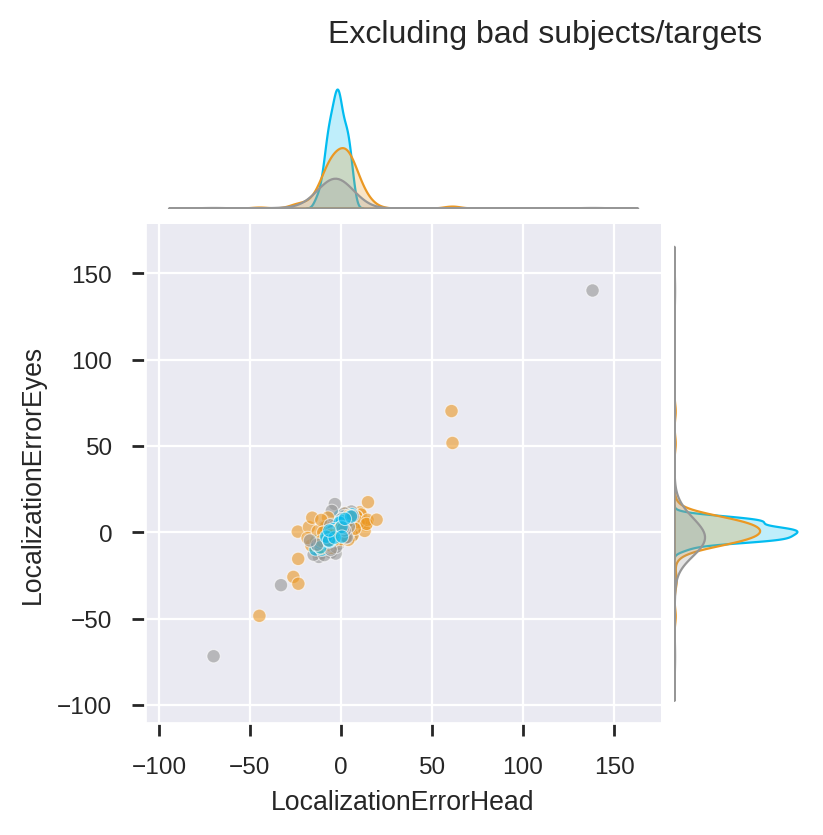

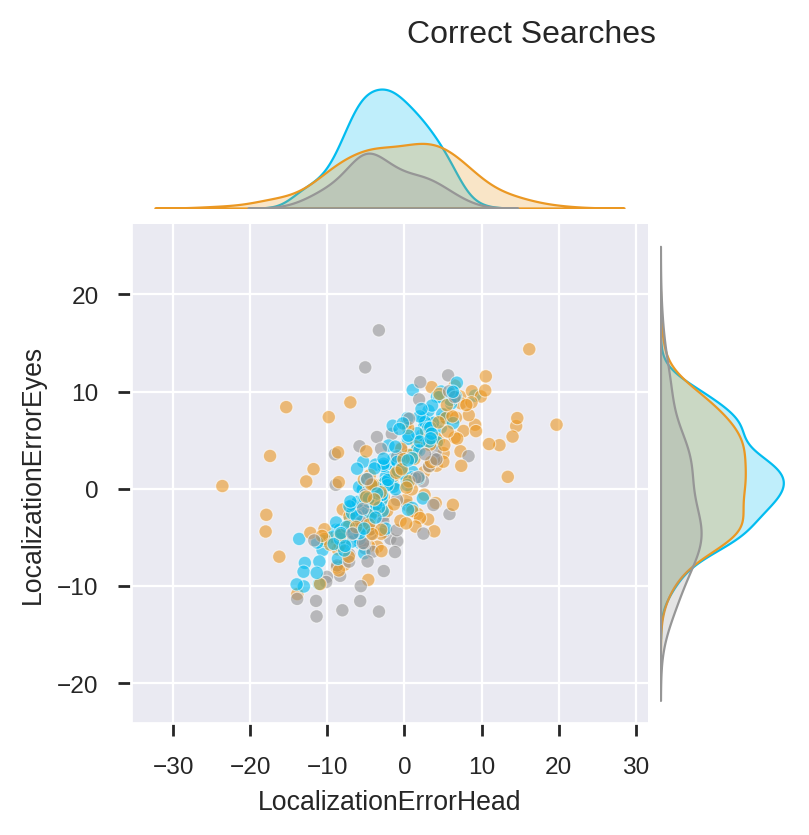

In [131]:
handles = visualization.joint_distribution_plots(valid_searches, [('LocalizationErrorHead','LocalizationErrorEyes')])
plt.suptitle('Excluding bad subjects/targets')
handles = visualization.joint_distribution_plots(succesfull_searches, [('LocalizationErrorHead','LocalizationErrorEyes')])
plt.suptitle('Correct Searches')
plt.show()

In [173]:
# def get_colors(labels, cmap='viridis', alpha=0.25):
#     colormap = matplotlib.colormaps.get_cmap(cmap)
#     colors = colormap(np.linspace(0,1,len(labels)))
#     colors[:,-1]=alpha
#     return {lbl: colors[i].tolist() for i, lbl in enumerate(labels)}

# idx = np.random.randint(0,200 ,10)

# lbl = successful_searches.iloc[idx].ActiveTarget
# color_LUT = get_colors(lbl)
# colors = [color_LUT[l] for l in lbl]

# trg_pos = successful_searches.TrgPosXZ.values[idx]
# org_pos = successful_searches.OrgPosXZ.values[idx]
# head_dir = successful_searches.Head2HeadPnt.values[idx]
# head_pos = successful_searches.HeadPosXZ.values[idx]

# plt.quiver(head_pos.real, head_pos.imag, head_dir.real, head_dir.imag, scale = 7, color=colors)
# plt.scatter(trg_pos.real, trg_pos.imag, c=colors)
# plt.plot(org_pos.real, org_pos.imag, '.')

## DATA ENDPOINTS

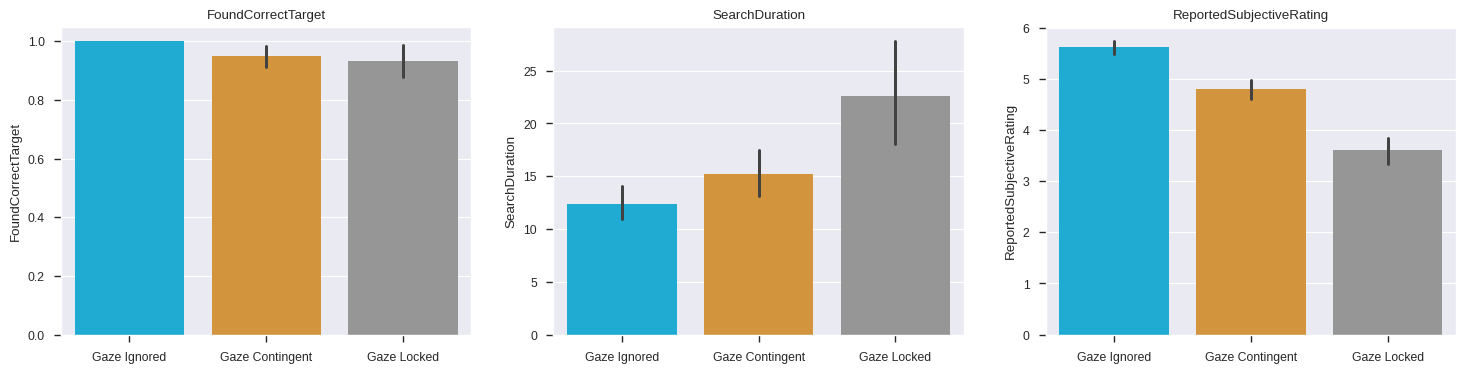

In [133]:
# Load the data used for plotting
localization_errors = pd.read_csv('out/all_localization_errors.tsv', sep='\t').set_index(['TrialIdentifier','ReportedEventsCount'])
valid_searches =  pd.read_csv('out/valid_localization_errors.tsv', sep='\t').set_index(['TrialIdentifier','ReportedEventsCount'])
successful_searches =  valid_searches.loc[valid_searches.FoundCorrectTarget]


# Plot primary endpoints
endpoints = ['FoundCorrectTarget', 'SearchDuration','ReportedSubjectiveRating']
visualization.set_figurestyle()
fig, axs = visualization.bar_plots(valid_searches, endpoints)
visualization.redefine_x_ticks(axs, remove_xlabel=True)

## Averaged per subject

In [123]:
group = stats.GROUP # default: grouping by subject

#### Primary endpoints: 
FoundCorrectTarget, SearchDuration, ReportedSubjectiveRating

Text(0.5, 0.98, 'Primary endpoints (correctly found targets)')

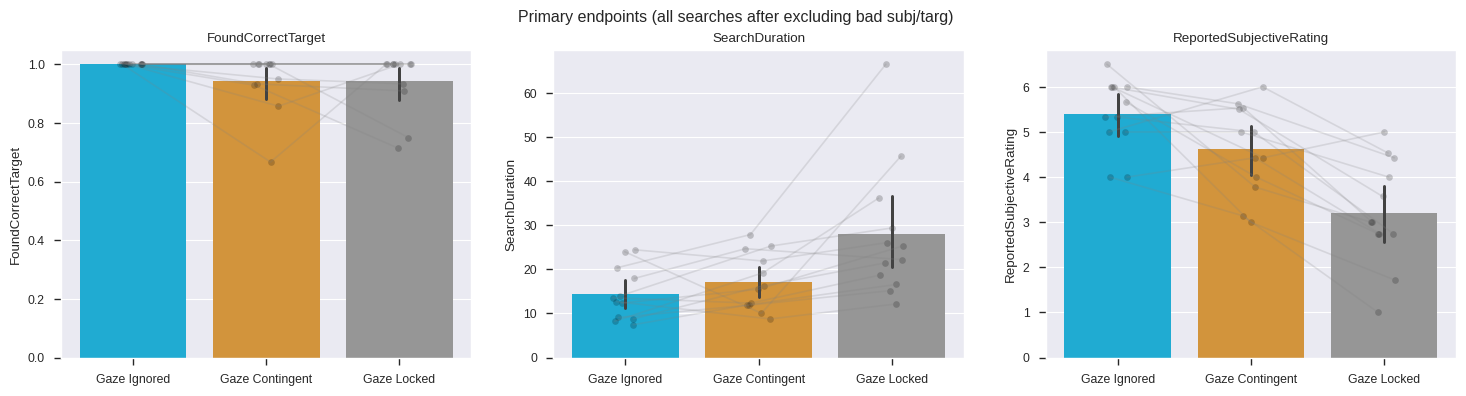

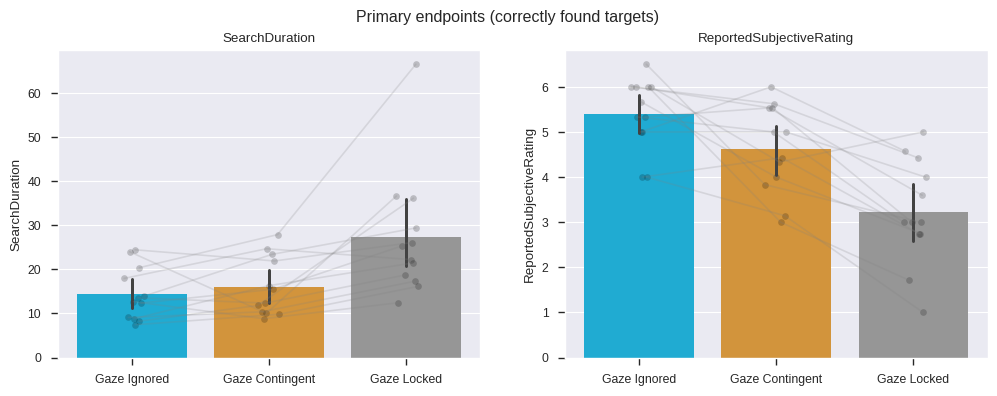

In [194]:
endpoints = ['FoundCorrectTarget', 'SearchDuration','ReportedSubjectiveRating']
avg = stats.average(valid_searches,y=endpoints,group=group)
fig, axs = visualization.bar_plots(avg, endpoints)
visualization.swarm_plots(avg, endpoints, axs=axs, alpha =.2)
visualization.redefine_x_ticks(axs, remove_xlabel=True)
plt.suptitle('Primary endpoints (all searches after excluding bad subj/targ)')

## Save data for plotting
# avg.to_csv(f'out/averaged_per_{group}.tsv', sep='\t', index=False)


endpoints = ['SearchDuration','ReportedSubjectiveRating']
avg = stats.average(successful_searches,y=endpoints,group=group)
fig, axs = visualization.bar_plots(avg, endpoints)
visualization.swarm_plots(avg, endpoints, axs=axs, alpha =.2)
visualization.redefine_x_ticks(axs, remove_xlabel=True)
plt.suptitle('Primary endpoints (correctly found targets)')
# visualization.add_panel_index(axs[0],'B')

# # Save data for plotting
# avg.to_csv(f'out/averaged_per_{group}.tsv', sep='\t', index=False)

#### Secondary endpoints
Localization error eyes / head / hand

Text(0.5, 0.98, 'Localization errors (correctly found targets)')

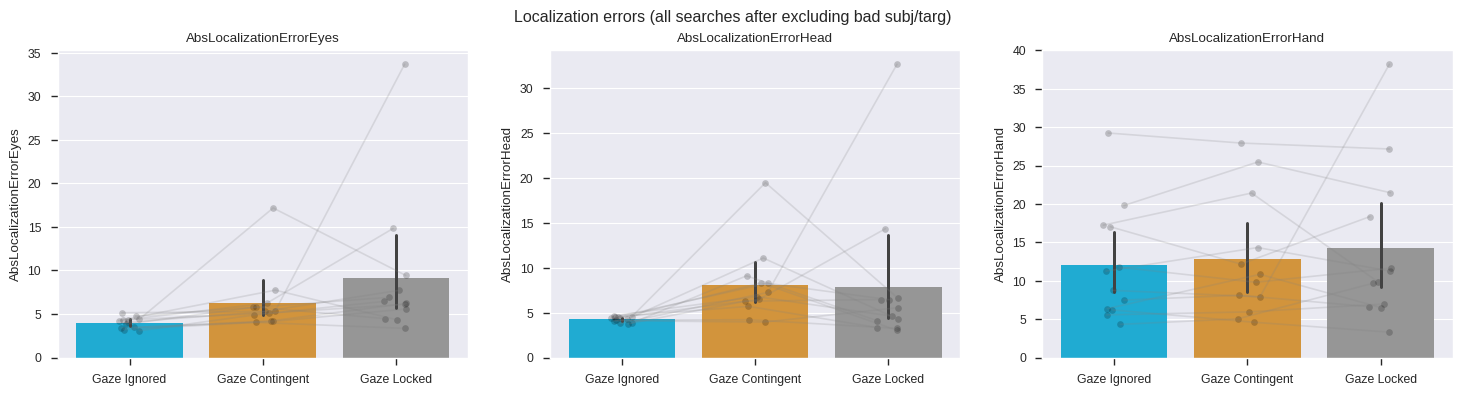

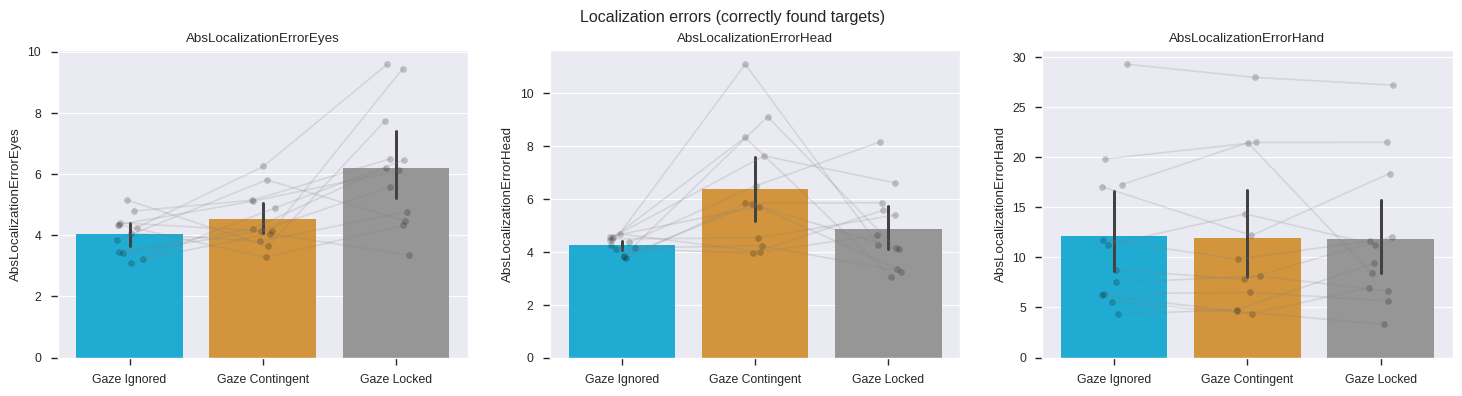

In [176]:
endpoints = ['AbsLocalizationErrorEyes','AbsLocalizationErrorHead','AbsLocalizationErrorHand']
avg = stats.average(valid_searches,y=endpoints,group=group)
fig, axs = visualization.bar_plots(avg, endpoints)
visualization.swarm_plots(avg, endpoints, axs=axs, alpha =.2)
visualization.redefine_x_ticks(axs, remove_xlabel=True)
plt.suptitle('Localization errors (all searches after excluding bad subj/targ)')

avg = stats.average(successful_searches,y=endpoints,group=group)
fig, axs = visualization.bar_plots(avg, endpoints)
visualization.swarm_plots(avg, endpoints, axs=axs, alpha =.2)
visualization.redefine_x_ticks(axs, remove_xlabel=True)
plt.suptitle('Localization errors (correctly found targets)')